Index: 01

Date: 2022/1/26

Questions:
Why there are around 200 duplicate geometries?

In [1]:
# !pip install geopandas

In [1]:
import pandas as pd
import numpy as np
import geopandas
import shapely
from geopandas.tools import sjoin
from os import listdir
from scipy.spatial import cKDTree
import itertools
from operator import itemgetter
import math

Notes: If having trouble installing geopandas (/fiona/GDAL), please visit https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal and https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona to find supported whls (Note: cp37 means python version 3.7). Then `pip install GDAL-xxx.whl`, `set GDAL_VERSION=xxx`, `pip install Fiona-xxx.whl` , and lastly `pip install geopandas`.

If there is problem with shapely.geos, first pip uninstall shapely within conda prompt, then conda install shapely.

In [12]:
# Import farm coordinates from the excel file as a dataframe.
farm_coordinates = pd.read_csv('final_lottery_locations.csv')
farm_coordinates = farm_coordinates.dropna(subset=['lon', 'lat'])

# Change the points dataframe to a GeoDataFrame with geometry given by longitude and latitude variables.
point_all = geopandas.GeoDataFrame(
    farm_coordinates, 
    geometry=geopandas.points_from_xy(farm_coordinates.lon, farm_coordinates.lat))

# Set Coordinate Reference System (CRS) to be epsg:4326, or the WGS84 latitude-longitude projection.
point_all = point_all.set_crs(epsg=4326)

Shape join points and polygons to find shapefiles of the solar farms.

In [16]:
def merge_point_poly(poly_file_path, point_all):
    """
    Find polygons that have at least a target point inside their boundaries.
    Input: poly_file_path: str, file path of the shapefile of polygons.
           point_all: GeoDataFrame, GeoDataFrame of points.
    Output: GeoDataFrame, GeoDataFrame of polygons that has at least one target point inside.
    """
    # Construct a GeoDataFrame of polygons from the shapefile.
    poly = geopandas.GeoDataFrame.from_file(poly_file_path)
    # Transform all geometries in a point_all to crs of the polygon shapfile. 
    point = point_all.to_crs(poly.crs)
    # Spatial join of point and poly, and keep geometry of poly as the geometry of the new shapefile.
    # (It only keeps the geometry from the left GeoDataFrame. 
    pointPolys = sjoin(poly, point, how='inner')
    # Select those entries without nan.
    # pointPolys[~(pointPolys.index_left.isna())]
    return pointPolys

In [17]:
# Try if it works as designed
# a = merge_point_poly('il/il001/clu_public_a_il001.shp', point_all)

Loop through all shapefiles in Illinois and concatenate all merged fields together.

In [18]:
# Loop through all shapefiles in Illinois.
list_file = listdir('il')
for i in range(len(list_file)):
    file_name = list_file[i]
    if i ==0:
        output = merge_point_poly('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all)
    else:
        m = merge_point_poly('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all)
        # Appended geometry columns needs to have the same CRS.
        m.to_crs(output.crs, inplace=True)
        output = output.append(m)

In [19]:
output.reset_index(drop=True, inplace=True)
output.reset_index(inplace=True)
solar_farms = output

In [9]:
# Output to a csv file
solar_farms.to_csv('merged_fields_by_point.csv')

Another way to merge. Create a 5-meter (parameter able to change) buffer around each field point, then find the overlapping areas with each field shape, merge with the field that has largest overlapping areas with the buffer.

In [10]:
def merge_by_max_ov(poly_file_path, point_all, radius, i):
    """
    Find polygons that shares largest area with the buffers of the points.
    Input: poly_file_path: string, file path of the field shapefile.
           point_all: geopandas dataframe, geodataframe of field addresses.
           radius: float/int/double, takes meter as its unit.
           i: int, number of the shapefile.
    """
    # Construct a GeoDataFrame of polygons from the shapefile.
    poly = geopandas.GeoDataFrame.from_file(poly_file_path)
    # Add field ID to the GeoDataFrame.
    poly.reset_index(inplace=True)
    poly.rename(columns={'index': 'field_ID'}, inplace=True)
    # Transform all geometries in a point_all to crs of the polygon shapfile. 
    point = point_all.to_crs(poly.crs)
    point.geometry = point.buffer(radius)
    # Spatial overlay.
    s = geopandas.overlay(point, poly, how = 'intersection')
    # Calculate overlapping area and get the maximum.
    s['area_ov'] = s.geometry.area
    gb = s.groupby('Application ID')[['area_ov']].max()
    # Add the column 'area_ov' which is the max area overlapping to the original gdf.
    point = point.merge(gb, left_on = 'Application ID', right_index = True)
    # Drop extraneous columns from the joined gdf
    s = s[['Application ID','field_ID', 'area_ov']]
    s['shape_file_ID'] = i
    # Merge the attribute column to the original gdf.
    point = point.merge(s, on=['Application ID', 'area_ov'])
    # Change the geometry to corresponding field shapefiles.
    point.drop(columns=['geometry'], inplace=True)
    point = point.merge(poly, on=['field_ID'])
    return point

In [18]:
# Loop through all shapefiles in Illinois.
list_file = listdir('il')
radius = 30
for i in range(len(list_file)):
    file_name = list_file[i]
    if i ==0:
        output = merge_by_max_ov('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all, radius, i)
    else:
        m = merge_by_max_ov('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all, radius, i)
        # Appended geometry columns needs to have the same CRS.
        m.to_crs(output.crs, inplace=True)
        output = output.append(m)
# Only keep entries with largest overlapping area for each application ID.
idx = output.groupby(['Application ID'])['area_ov'].transform(max) == output['area_ov']
output = output[idx]
# Output to a csv file
output.to_csv('merged_fields_by_area_30.csv')

In [18]:
# Loop through all shapefiles in Illinois.
list_file = listdir('il')
radius = 60
for i in range(len(list_file)):
    file_name = list_file[i]
    if i ==0:
        output = merge_by_max_ov('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all, radius, i)
    else:
        m = merge_by_max_ov('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all, radius, i)
        # Appended geometry columns needs to have the same CRS.
        m.to_crs(output.crs, inplace=True)
        output = output.append(m)
# Only keep entries with largest overlapping area for each application ID.
idx = output.groupby(['Application ID'])['area_ov'].transform(max) == output['area_ov']
output = output[idx]
# Output to a csv file
output.to_csv('merged_fields_by_area_60.csv')

In [18]:
# Loop through all shapefiles in Illinois.
list_file = listdir('il')
radius = 100
for i in range(len(list_file)):
    file_name = list_file[i]
    if i ==0:
        output = merge_by_max_ov('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all, radius, i)
    else:
        m = merge_by_max_ov('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all, radius, i)
        # Appended geometry columns needs to have the same CRS.
        m.to_crs(output.crs, inplace=True)
        output = output.append(m)
# Only keep entries with largest overlapping area for each application ID.
idx = output.groupby(['Application ID'])['area_ov'].transform(max) == output['area_ov']
output = output[idx]
# Output to a csv file
output.to_csv('merged_fields_by_area_100.csv')

### Choose which merged result is the best fit.

In [24]:
# This is the file that has all information from merging results by 
# point/30/60/90 that I matched by vlookup in excel. 
# It should be changed to dataframe merging function in the Jupyter here.
merged_df = pd.read_csv('final_lottery_locations_merge_results.csv')

In [25]:
merged_df.drop(columns=['Unnamed: 0'], inplace=True)

Check each row to choose from the merging results the best fit ones.

In [26]:
merged_final = []
merged_source = []
comment = []
# Threshold can be changed for robustness check. 
# Here merging results less than 5 acres are regarded as not valid.
threshold = 5
for i in range(len(merged_df)):
    row = merged_df.iloc[i]
    comment.append('')
    print(i)
    if isinstance(row.Merged_by_point, float):
        # Then 30, 60, and/or 100 may have values
        if isinstance(row.Merged_by_area_30, float):
            # Then 60 and/or 100 may have values.
            if isinstance(row.Merged_by_area_60, float):
                if isinstance(row.Merged_by_area_100, float):
                    merged_final.append(row.Merged_by_area_100)
                    merged_source.append([])
                else:
                    merged_final.append(row.Merged_by_area_100)
                    merged_source.append(['100'])
            elif row.Merged_by_area_60 == row.Merged_by_area_100:
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['60', '100'])
            elif row.Acreage_60 < threshold:
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['100'])
            else:
                merged_final.append(row.Merged_by_area_60)
                merged_source.append(['60'])
                comment[-1] = 'check between 60 and 100'
        else:
            # Then 30, 60, 100 all have values.
            if (row.Merged_by_area_30 == row.Merged_by_area_60) and (row.Merged_by_area_60 == row.Merged_by_area_100):
                merged_final.append(row.Merged_by_area_30)
                merged_source.append(['30', '60', '100'])
            elif (row.Merged_by_area_30 == row.Merged_by_area_60) and (row.Acreage_30 < threshold):
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['100'])
            elif row.Merged_by_area_30 == row.Merged_by_area_60:
                merged_final.append(row.Merged_by_area_30)
                merged_source.append(['30', '60'])
                comment[-1] = 'check between 30 and 100'
            elif (row.Merged_by_area_60 == row.Merged_by_area_100) and (row.Acreage_30 < threshold):
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['60', '100'])
            elif row.Merged_by_area_60 == row.Merged_by_area_100:
                merged_final.append(row.Merged_by_area_30)
                merged_source.append(['30'])
                comment[-1] = 'check between 30 and 60'
            elif (row.Acreage_30 < threshold) and (row.Acreage_60 < threshold):
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['100'])
            elif row.Acreage_30 < threshold:
                merged_final.append(row.Merged_by_area_60)
                merged_source.append(['60'])
                comment[-1] = 'check between 60 and 100'
            elif row.Acreage_60 < threshold:
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['100'])
            else:
                merged_final.append(row.Merged_by_area_30)
                merged_source.append(['30'])
                comment[-1] = 'check among 30, 60, 100'
    else:
        # Then all have values.
        if row.Merged_by_point == row.Merged_by_area_30:
            if (row.Merged_by_area_30 == row.Merged_by_area_60) and (row.Merged_by_area_60 == row.Merged_by_area_100):
                merged_final.append(row.Merged_by_point)
                merged_source.append(['point', '30', '60', '100'])
            elif (row.Merged_by_area_30 == row.Merged_by_area_60) and (row.Acreage_60 < threshold):
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['100'])
            elif row.Merged_by_area_30 == row.Merged_by_area_60:
                merged_final.append(row.Merged_by_area_60)
                merged_source.append(['point', '30', '60'])
                comment[-1] = 'check between point and 100'
            elif (row.Acreage_30 < threshold) and (row.Merged_by_area_60 == row.Merged_by_area_100):
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['60', '100'])
            elif (row.Acreage_30 < threshold) and (row.Acreage_60 < threshold):
                merged_final.append(row.Merged_by_area_100)
                merged_source.append(['100'])
            elif row.Acreage_30 < threshold:
                merged_final.append(row.Merged_by_area_60)
                merged_source.append(['60'])
                comment[-1] = 'check between 60 and 100'
            else:
                merged_final.append(row.Merged_by_area_30)
                merged_source.append(['point', '30'])
                comment[-1] = 'check among 30, 60, 100'
        else:
            # All have values, point not equals to 30.
            if row.Acreage_point < threshold:
                if row.Acreage_30 < threshold:
                    if row.Acreage_60 < threshold:
                        if row.Acreage_100 < threshold:
                            merged_final.append(row.Merged_by_point)
                            merged_source.append(['point'])
                            comment[-1] = 'check all'
                        else:
                            merged_final.append(row.Merged_by_area_100)
                            merged_source.append(['100'])
                    elif row.Merged_by_area_60 == row.Merged_by_area_100:
                        merged_final.append(row.Merged_by_area_100)
                        merged_source.append(['60', '100'])
                    else:
                        merged_final.append(row.Merged_by_area_60)
                        merged_source.append(['60'])
                        comment[-1] = 'check between 60 and 100'
                else:
                    if (row.Merged_by_area_30 == row.Merged_by_area_60) and (row.Merged_by_area_60 == row.Merged_by_area_100):
                        merged_final.append(row.Merged_by_area_60)
                        merged_source.append(['30','60','100'])
                    elif row.Merged_by_area_30 == row.Merged_by_area_60:
                        merged_final.append(row.Merged_by_area_60)
                        merged_source.append(['30','60'])
                        comment[-1] = 'check between 60 and 100'
                    else:
                        merged_final.append(row.Merged_by_area_30)
                        merged_source.append(['30'])
                        comment[-1] = 'check among 30, 60, 100'
            else:
                if (row.Merged_by_area_30 == row.Merged_by_area_60) and (row.Merged_by_area_60 == row.Merged_by_area_100):
                    merged_final.append(row.Merged_by_point)
                    merged_source.append(['point'])
                    comment[-1] = 'check between point and 30'
                elif row.Merged_by_area_30 == row.Merged_by_area_60:
                    merged_final.append(row.Merged_by_point)
                    merged_source.append(['point'])
                    comment[-1] = 'check among point, 30, 100'
                elif row.Merged_by_area_60 == row.Merged_by_area_100:
                    merged_final.append(row.Merged_by_point)
                    merged_source.append(['point'])
                    comment[-1] = 'check among point, 30, 60'
                else:
                    merged_final.append(row.Merged_by_point)
                    merged_source.append(['point'])
                    comment[-1] = 'check all'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
merged_df['merged_final']=merged_final
merged_df['merged_source']=merged_source
merged_df['comment']=comment
merged_df.to_csv('merged_df.csv')

### Check the polygon shapes

In [ ]:
shapefile_ID = 
field_ID_1 = 
field_ID_2 = 
poly_file_path = 'il/'+shapefile_ID+'/clu_public_a_'+shapefile_ID+'.shp'
poly = geopandas.GeoDataFrame.from_file(poly_file_path)

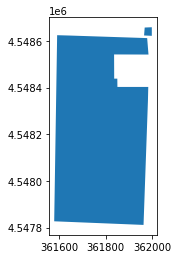

In [17]:
poly.iloc[[field_ID_1, field_ID_2]].plot()

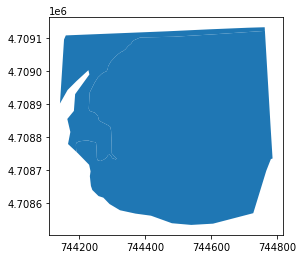

In [85]:
poly.iloc[[24089,24090]].plot()

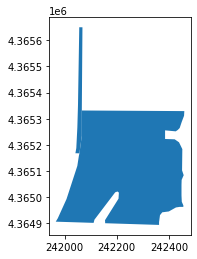

In [78]:
poly.iloc[[24427,31203]].plot()

### Obtain information of all fields within the maximum distances.

Get centroids of each field and store in a geopandas dataframe.

In [28]:
acreage = []
for i in range(len(merged_df)):
    row = merged_df.iloc[i]
    if 'point' in row.merged_source:
        acreage.append(row.Acreage_point)
    elif '30' in row.merged_source:
        acreage.append(row.Acreage_30)
    elif '60' in row.merged_source:
        acreage.append(row.Acreage_60)
    elif '100' in row.merged_source:
        acreage.append(row.Acreage_100)
    else:
        acreage.append(np.nan)

In [29]:
merged_df['acreage']=acreage

In [30]:
merged_df.drop(columns=['Merged_by_point', 'Acreage_point',
       'Merged_by_area_30', 'Acreage_30', 'Shapefile_ID_30', 'Field_ID_30',
       'Merged_by_area_60', 'Acreage_60', 'Shapefile_ID_60', 'Field_ID_60',
       'Merged_by_area_100', 'Acreage_100', 'Shapefile_ID_100', 'Field_ID_100',
       'Comment'],inplace=True)

In [32]:
merged_df['merged_final'] = geopandas.GeoSeries.from_wkt(merged_df['merged_final'])
fields = geopandas.GeoDataFrame(
    merged_df, 
    geometry=merged_df.merged_final,
    crs=output.crs)

In [33]:
fields.drop(columns=['merged_final'], inplace=True)

In [34]:
field_centroid = geopandas.GeoDataFrame(geometry=fields.centroid)
field_centroid.reset_index(inplace=True)

<AxesSubplot:>

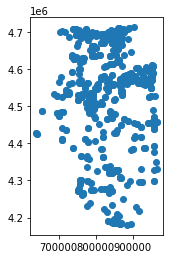

In [35]:
field_centroid.plot()

In [36]:
field_centroid.dropna(subset=['geometry'], inplace=True)

In [37]:
field_centroid

,index,geometry
0,0,POINT (894458.667 4647563.391)
1,1,POINT (865871.881 4556043.143)
2,2,POINT (864607.599 4707850.336)
3,3,POINT (864607.599 4707850.336)
4,4,POINT (825229.795 4336169.599)
...,...,...
840,840,POINT (747311.345 4707861.340)
846,846,POINT (747311.345 4707861.340)
848,848,POINT (894544.179 4570741.435)
858,858,POINT (904164.108 4713302.016)


Import Homeland Infrastructure Foundation-Level Data (HIFLD) (downloaded shapefiles).

In [38]:
electricity = geopandas.GeoDataFrame.from_file('Electric_Substations/Substations.shp')
electricity.to_crs(field_centroid.crs, inplace=True)

Find nearest infrastructure lines around the centroids.

Useful link: https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas

In [39]:
def min_dist(point, gpd2):
    """
    Calculate distances from point to each point in gpd2, and sort out the nearest point.
    Input: point: a point geometry.
           gpd2: a geopandas dataframe of points.
    """
    gpd2['Dist'] = gpd2.apply(lambda row: point.distance(row.geometry),axis=1)
    geoseries = gpd2.iloc[gpd2['Dist'].argmin()]
    return geoseries

field_centroid['Nearest'] = field_centroid.apply(lambda row: min_dist(row.geometry, electricity)['ID'] , axis=1)
electricity.drop(columns=['Dist'], inplace=True)

In [40]:
field_centroid.drop_duplicates(subset=['geometry'], inplace=True)
field_centroid.reset_index(drop=True, inplace=True)

In [41]:
field_centroid

,index,geometry,Nearest
0,0,POINT (894458.667 4647563.391),122227
1,1,POINT (865871.881 4556043.143),134655
2,2,POINT (864607.599 4707850.336),121928
3,4,POINT (825229.795 4336169.599),170249
4,5,POINT (841204.055 4686945.721),122296
...,...,...,...
501,836,POINT (937758.519 4594469.217),122013
502,840,POINT (747311.345 4707861.340),136979
503,848,POINT (894544.179 4570741.435),134648
504,858,POINT (904164.108 4713302.016),167144


In [42]:
# Construct a geopandas dataframe of the nearest towers in the same order of the field centroids of the solar farms.
nearest_towers = field_centroid.copy().drop(columns=['geometry'])
nearest_towers = nearest_towers.merge(electricity, left_on='Nearest', right_on='ID', how='left')

# Calculate distances from centroid of fields to the nearest towers.
# Unit in EPSG:26915 is metre, so the distances are in meters.
field_centroid['dist_nearest_tower'] = field_centroid.distance(nearest_towers)

# Merge other attributes of the nearest tower.
nearest_towers.drop(columns=['geometry', 'Nearest', 'index'], inplace=True)
field_centroid = pd.concat([field_centroid , nearest_towers], axis=1)

# Calculate the greatest accepted distance to each tower.
field_centroid['max_dist'] = field_centroid.groupby(['ID'])['dist_nearest_tower'].transform(max)

In [43]:
# Get all fields within the max distance of each tower.
towers = field_centroid.copy().drop_duplicates(subset=['ID'])
towers.reset_index(drop=True, inplace=True)
towers['geometry'] = towers.buffer(towers.max_dist)
towers.drop(columns=['Nearest', 'dist_nearest_tower'], inplace=True)

<AxesSubplot:>

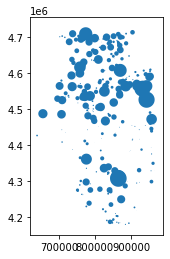

In [44]:
towers.plot()

In [45]:
def merge_point_poly_2(poly_file_path, buf):
    """
    Find polygons whose centroids are within the buffer zone.
    Input: poly_file_path: str, file path of the shapefile of polygons.
           buf: GeoDataFrame, GeoDataFrame of buffers of points.
    Output: GeoDataFrame, GeoDataFrame of polygons whose centroids are within the buffer zone.
    """
    # Construct a GeoDataFrame of polygons from the shapefile.
    poly = geopandas.GeoDataFrame.from_file(poly_file_path)
    poly_centroid = poly.copy()
    poly_centroid['geometry'] = poly.centroid
    # Transform all geometries in a point_all to crs of the polygon shapfile. 
    buf = buf.to_crs(poly.crs)
    # Spatial join of point and poly, and keep geometry of poly as the geometry of the new shapefile.
    # (It only keeps the geometry from the left GeoDataFrame. 
    pointPolys = sjoin(poly_centroid, buf, how='inner')
    # Replace the geometry with polygons. Matching by index.
    if len(pointPolys)!=0:
        pointPolys.loc[:, ['geometry']] = poly[['geometry']]
    return pointPolys

In [46]:
# Loop through all shapefiles in Illinois. Find all fields that are within the maximum distances from the electricity towers.
list_file = listdir('il')
for i in range(len(list_file)):
    file_name = list_file[i]
    if i ==0:
        output_2 = merge_point_poly_2('il/'+file_name+'/clu_public_a_'+file_name+'.shp', towers)
    else:
        m = merge_point_poly_2('il/'+file_name+'/clu_public_a_'+file_name+'.shp', towers)
        # Appended geometry columns needs to have the same CRS.
        m.to_crs(output_2.crs, inplace=True)
        output_2 = output_2.append(m)

In [47]:
output_2.dropna(subset=['ID'], inplace=True)

In [48]:
output_2.reset_index(drop=True, inplace=True)

<AxesSubplot:>

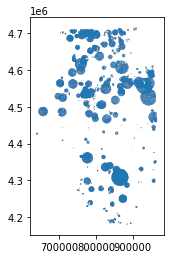

In [49]:
output_2.plot()

In [50]:
# Calculate the distance to nearest towers. (Or to the towers in our dataset?)
output_2.centroid

0         POINT (641025.884 4426721.642)
1         POINT (637763.765 4428424.866)
2         POINT (638528.047 4428406.495)
3         POINT (637381.020 4425506.343)
4         POINT (637589.643 4425806.847)
                       ...              
461717    POINT (833434.518 4466130.701)
461718    POINT (833475.784 4465875.944)
461719    POINT (833405.580 4466183.442)
461720    POINT (801575.521 4544772.012)
461721    POINT (801640.162 4544211.495)
Length: 461722, dtype: geometry

In [52]:
output_2.columns

Index(['CALCACRES', 'geometry', 'index_right', 'index', 'OBJECTID', 'ID',
       'NAME', 'CITY', 'STATE', 'ZIP', 'TYPE', 'STATUS', 'COUNTY',
       'COUNTYFIPS', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'NAICS_CODE',
       'NAICS_DESC', 'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'LINES',
       'MAX_VOLT', 'MIN_VOLT', 'MAX_INFER', 'MIN_INFER', 'max_dist'],
      dtype='object')

In [53]:
electricity.columns

Index(['OBJECTID', 'ID', 'NAME', 'CITY', 'STATE', 'ZIP', 'TYPE', 'STATUS',
       'COUNTY', 'COUNTYFIPS', 'COUNTRY', 'LATITUDE', 'LONGITUDE',
       'NAICS_CODE', 'NAICS_DESC', 'SOURCE', 'SOURCEDATE', 'VAL_METHOD',
       'VAL_DATE', 'LINES', 'MAX_VOLT', 'MIN_VOLT', 'MAX_INFER', 'MIN_INFER',
       'geometry'],
      dtype='object')

In [54]:
# Construct a geopandas dataframe of the nearest towers in the same order of the field centroids of the solar farms.
nearest_towers = output_2.copy().drop(columns=['geometry'])
nearest_towers = nearest_towers.merge(electricity, left_on='ID', right_on='ID', how='left')

# Calculate distances from centroid of fields to the nearest towers.
# Unit in EPSG:26915 is metre, so the distances are in meters.
output_2['dist_nearest_tower'] = output_2.distance(nearest_towers)

In [56]:
output_2.to_file("AllFields.shp")

<ipython-input-56-8f6a7f58613d>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  output_2.to_file("AllFields.shp")
